<a href="https://colab.research.google.com/github/kongwanbianjinyu/Deep-Learning-Tutorial/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
## Standard libraries
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "drive/MyDrive/deep learning tutorial/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "drive/MyDrive/deep learning tutorial/saved_models/AutoEncoder"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda:0


In [57]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial9/"
# Files to download
pretrained_files = ["cifar10_64.ckpt", "cifar10_128.ckpt", "cifar10_256.ckpt", "cifar10_384.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder")

In [58]:
# Transformations applied on each image => only make them a tensor
# scale the data between [-1,1]
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Files already downloaded and verified


Global seed set to 42


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# AutoEncoder

## CNN Encoder

In [59]:
class Encoder(nn.Module):
  def __init__(self, num_input_channels, base_channel_size, latent_dim, act_fn = nn.GELU):
    super().__init__()
    c_hid = base_channel_size
    self.net = nn.Sequential(
        # [3,32,32] -> [c_hid, 16,16]
        nn.Conv2d(num_input_channels, c_hid, kernel_size = 3, padding = 1, stride = 2),
        act_fn(),
        nn.Conv2d(c_hid, c_hid, kernel_size = 3, padding = 1),
        act_fn(),
        # [c_hid, 16,16] -> [2*c_hid, 8,8]
        nn.Conv2d(c_hid, 2* c_hid, kernel_size = 3, padding = 1, stride = 2),
        act_fn(),
        nn.Conv2d(2* c_hid, 2* c_hid, kernel_size = 3, padding = 1),
        act_fn(),
        # [2*c_hid, 8,8] -> [2*c_hid, 4, 4]
        nn.Conv2d(2* c_hid, 2* c_hid, kernel_size = 3, padding = 1, stride = 2),
        act_fn(),
        # [2*c_hid*4*4,1]
        nn.Flatten(),
        nn.Linear(2*4*4*c_hid,latent_dim)
        
    )

  def forward(self, x):
    return self.net(x)


## CNN Decoder

In [60]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

## AutoEncoder lightning module

In [61]:
class Autoencoder(pl.LightningModule):
  def __init__(self,base_channel_size, latent_dim, encoder_class = Encoder, decoder_class = Decoder, num_input_channels = 3, width = 32, height = 32):
    super().__init__()
    self.save_hyperparameters()

    # encoder, decoder
    self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
    self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

  def forward(self, x):
    z = self.encoder(x)
    x_hat = self.decoder(z)
    return x_hat

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=1e-3)
    # Using a scheduler is optional but can be helpful.
    # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      mode='min',
                                                      factor=0.2,
                                                      patience=20,
                                                      min_lr=5e-5)
    return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

  def get_loss(self,batch):
    x, _ = batch
    x_hat = self.forward(x)
    loss = F.mse_loss(x,x_hat, reduction = "none")
    # sum over each pixels, mean over batches
    loss = loss.sum(dim = [1,2,3]).mean(dim = [0])
    return loss

  def train_step(self, batch, batch_idx):
    loss = self.get_loss(batch)
    self.log("train_loss", loss)

  def validation_step(self, batch, batch_idx):
    loss = self.get_loss(batch)
    self.log('val_loss', loss)

  def test_step(self, batch, batch_idx):
    loss = self.get_loss(batch)
    self.log('test_loss', loss)




## Train Lightning 

In [70]:
class GenerateCallback(pl.Callback):
  def __init__(self, input_imgs, every_n_epochs = 1):
    super().__init__()
    self.input_imgs = input_imgs
    self.every_n_epochs = every_n_epochs

  def on_epoch_end(self, trainer, pl_module):
    if trainer.current_epoch % self.every_n_epochs == 0:
      input_imgs = self.input_imgs.to(pl_module.device)
      # Reconstruct images
      with torch.no_grad():
        pl_module.eval()
        x_hat = pl_module(input_imgs)
        pl_module.train()
      # plot images to tensorboard
      # input_imgs, x_hat [B,C,H,W], after stack: [B,2,C,H,W], after flatten dim 0 and dim1: [2*B,C,H,W]
      imgs = torch.stack([input_imgs, x_hat], dim = 1).flatten(0,1)
      # imgs[2*B, C,H, W] ,nrow = 2:  each row show 2 imgs
      grid = torchvision.utils.make_grid(imgs, nrow = 2, normalize = True, range = (-1,1))
      trainer.logger.experiment.add_image("Reconstructions", grid, global_step = trainer.global_step)


In [63]:
def train_cifar(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}"),
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=500,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
        trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

In [64]:
input_imgs = get_train_images(8)
print(input_imgs.shape)
imgs = torch.stack([input_imgs, input_imgs],dim = 1)#.flatten(0,1)
print(imgs.shape)
#grid = torchvision.make_grid(imgs, nrow = 2, normalize = True, range = (-1,1))

torch.Size([8, 3, 32, 32])
torch.Size([8, 2, 3, 32, 32])


In [71]:
latent_dim = 128

model_ld, result_ld = train_cifar(latent_dim)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:386: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/tensorboard.py:251: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  "Could not log computational graph since the"


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [72]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = train_cifar(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:386: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  f"The `Callback.{hook}` hook was deprecated in v1.6 and"
Missing logger folder: drive/MyDrive/deep learning tutorial/saved_models/AutoEncoder/cifar10_64/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/tensorboard.py:251: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  "Could not log computational graph since the"


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/deep learning tutorial/saved_models/AutoEncoder/cifar10_256/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: drive/MyDrive/deep learning tutorial/saved_models/AutoEncoder/cifar10_384/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

# Visual Reconstruction

In [74]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


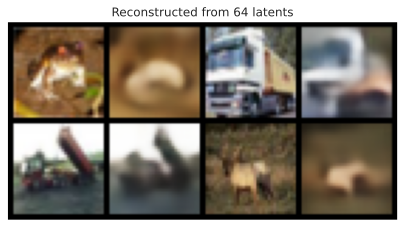

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


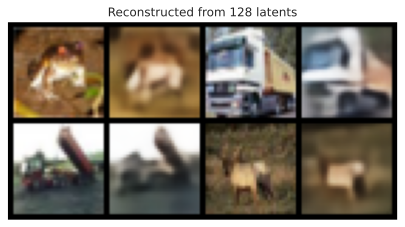

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


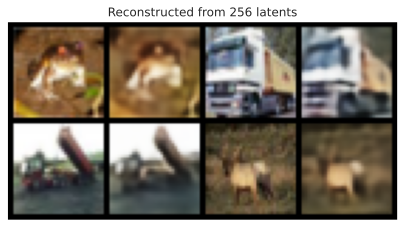

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:69: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  "The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. "


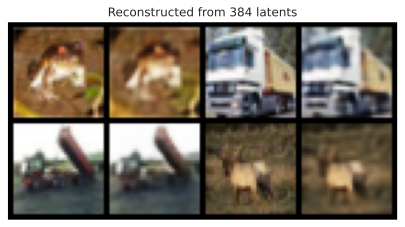

In [75]:
input_imgs = get_train_images(4)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)